In [27]:
import pandas as pd
import re
import numpy as np
from gensim.models import Word2Vec
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import joblib
from datetime import date
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
with open("../data/chat.txt", "r", encoding="utf-8") as f:
    linhas = f.readlines()

dados = []
for linha in linhas:
    match = re.match(r'(\d{2}/\d{2}/\d{4}) (\d{2}:\d{2}) - (.*?): (.*)', linha)
    if match and "<Mídia oculta>" not in match.group(4):
        data, hora, remetente, mensagem = match.groups()
        dados.append([data, hora, remetente, mensagem])
    else:
        continue


df = pd.DataFrame(dados, columns = ["data", "hora", "remetente", "mensagem"])

df["mensagem"] = df["mensagem"].str.lower()

df.head(10)

,data,hora,remetente,mensagem
0,06/08/2022,15:09,Jão,ae
1,06/08/2022,15:09,Jão,pronto
2,06/08/2022,15:09,Jão,quando forem jogar ou chamar
3,06/08/2022,15:09,André,boa
4,06/08/2022,15:09,Jão,fala por aq q geral vê mais fácil
5,06/08/2022,15:09,Jão,clipe tbem lança
6,06/08/2022,15:09,Jão,tamo togethar felas
7,06/08/2022,15:13,Caraio,brabo
8,06/08/2022,15:13,Kau,ganhamos inclusive
9,06/08/2022,15:13,Jão,boa rapeize


# Modelo NLP

In [3]:
sentencas = [msg.split() for msg in df["mensagem"]]

modelo_word = Word2Vec(sentences = sentencas, vector_size=100, window=5, min_count=5, workers=4)

def vetor_mensagem(msg, modelo):
    vetores = []
    for palavra in msg.split():
        if palavra in modelo_word.wv:
            vetores.append(modelo_word.wv[palavra])
    if vetores: 
        return np.mean(vetores, axis = 0)
    else:
        return np.zeros(modelo_word.vector_size)

df['vetor'] = df['mensagem'].apply(lambda x: vetor_mensagem(x, modelo_word))


In [4]:
df["data"] = pd.to_datetime(df["data"], format = '%d/%m/%Y')

df["ano_mes"] = df["data"].dt.to_period("M")

def amostra_mes(df, n = 10):
    amostra = df.groupby("ano_mes").apply(lambda x: x.sample(n = min(len(x), n), random_state = 27))
    amostra.reset_index(drop=True, inplace=True)
    return amostra

df_amostra = amostra_mes(df, 20)

df_amostra

,data,hora,remetente,mensagem,vetor
0,2022-08-15,18:41,Yuri,foi tudo combinado,"[-0.8937599, 0.29727024, 0.12749173, -0.177325..."
1,2022-08-07,19:44,Jão,tô,"[1.3221843, 1.2211084, 0.3729226, -0.6701051, ..."
2,2022-08-22,20:41,Kau,tao comendo o cu do bolsonaro na globo,"[0.60606384, 0.15125653, 0.45159522, -0.299451..."
3,2022-08-21,00:45,Yuri,ah mano,"[-0.37247106, -0.009339549, 0.08433479, 0.8118..."
4,2022-08-26,21:11,Jão,,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...
835,2026-01-21,21:51,Cauã,du nunca vi iss na vida,"[0.34628513, 0.6588874, 0.39481243, 0.47585845..."
836,2026-01-28,22:34,Guido,e deu a vida rindo loucamente,"[0.029073957, 0.30648452, 0.37287012, -0.06166..."
837,2026-01-28,12:52,Luquete,teria uma revolta,"[-0.2750977, 0.4870838, 0.21013996, -0.1068074..."
838,2026-01-28,15:10,Luquete,no governo do bolsonaro foi onde mais teve cor...,"[0.29593688, 0.33848128, 0.32716253, -0.316148..."


# Modelo Regressão

In [12]:
# Inputar valores manualmente

for i, msg in enumerate(df_amostra["mensagem"]):
    print(i, msg)
    df_amostra.loc[i, "sentimento"] = input("Sentimento (positivo/neutro/negativo)? ")

0 foi tudo combinado
1 tô
2 tao comendo o cu do bolsonaro na globo
3 ah mano
4 
5 mil vezes
6 3 emaptes
7 vc ta bebeado ainda mano?
8 e ai
9 eu n tomo
10 ta
11 tão cantando
12 se hd tá interferindo e tals
13 tô pô
14 do time
15 p jogar
16 tô livre age
17 né?
18 presente
19 a avó dele com ctz tá em casa
20 cara chato do cacete
21 outro cabelo do gabi
22 tô passando noampinho agr
23 .
24 nois vaza
25 jogar 14h30
26 do brasa
27 tbm
28 jaja tô aq
29 n to falando disso
30 jão ce ta em casa?
31 pd ou n?
32 o cara sai
33 .
34 aí andré, entra pf
35 aquele das 20h rola?
36 clipei uns lance vou mandar lá dps
37 mas são seis
38 meti do durmo
39 irmão
40 vai consta hoje?
41 top
42 pora
43 no insta deles
44 tem q ser cedo
45 votava na rose
46 uai mano nois tem q dar poder pra todo mundo né
47 tem eu tbm
48 é q 222 era magno malta mano
49 poha de rose kkkkk
50 porra é essa kkkkkkkkkkkkkk
51 a chance da gente se ver dnovo é mt baixa
52 coitado dos viado
53 pedro parker
54 pena q o time e uma merda
55

In [39]:
df_amostra["sent_bin"] = df_amostra["sentimento"].replace({
    "positivo": "resenha",
    "neutro": "nao_resenha",
    "negativo": "nao_resenha"
})

# exemplo
df_amostra["sent_bin"] = df_amostra["sent_bin"].map({
    "nao_resenha": 0,
    "resenha": 1
})

df_amostra["sent_bin"].value_counts()

sent_bin
0    632
1    208
Name: count, dtype: int64

In [43]:
X = np.vstack(df_amostra["vetor"].values)
Y = df_amostra["sent_bin"].values


X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.3, random_state=27, stratify=Y
)

modelo_reg = LogisticRegression(max_iter=1000, class_weight= "balanced")
modelo_reg.fit(X_train,Y_train)

proba = modelo_reg.predict_proba(X_test)[:, 1]

for t in [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    y_pred_t = (proba >= t).astype(int)
    print(f"\nThreshold = {t}")
    print(classification_report(Y_test, y_pred_t))


Threshold = 0.2
              precision    recall  f1-score   support

           0       0.89      0.17      0.29       190
           1       0.27      0.94      0.42        62

    accuracy                           0.36       252
   macro avg       0.58      0.55      0.35       252
weighted avg       0.74      0.36      0.32       252


Threshold = 0.3
              precision    recall  f1-score   support

           0       0.88      0.31      0.45       190
           1       0.29      0.87      0.44        62

    accuracy                           0.44       252
   macro avg       0.58      0.59      0.44       252
weighted avg       0.73      0.44      0.45       252


Threshold = 0.4
              precision    recall  f1-score   support

           0       0.85      0.42      0.56       190
           1       0.30      0.77      0.43        62

    accuracy                           0.50       252
   macro avg       0.58      0.59      0.50       252
weighted avg       0.71

Usar threshold em 0.6, modelo funciona, ta tudo top!!

In [ ]:
# Salvar modelos

joblib.dump(modelo_reg, "../modelos/modelo_resenha.pkl")
joblib.dump(modelo_word, "../modelos/vetorizador.pkl")

['modelos/vetorizador.pkl']

# Breve análise para montar pipeline

In [6]:
df['proba_resenha'] = modelo_reg.predict_proba(np.vstack(df["vetor"].values))[:, 1]
df["timestamp"] = df["data"] + pd.to_timedelta(df["hora"] + ":00")
df["hora_dt"] = df["timestamp"].dt.floor("h")
df_hora = (df.groupby("hora_dt").agg(media = ("proba_resenha", "mean"), n = ("proba_resenha", "count")).reset_index())

df_hora.head(5)

,hora_dt,media,n
0,2022-08-06 15:00:00,0.606951,18
1,2022-08-06 16:00:00,0.630378,2
2,2022-08-06 18:00:00,0.457240,5
3,2022-08-06 19:00:00,0.582273,12
4,2022-08-06 20:00:00,0.565044,9


In [7]:
intervalos = [
    ("00:00", "03:00"),
    ("04:00", "07:00"),
    ("08:00", "11:00"),
    ("12:00", "15:00"),
    ("16:00", "19:00"),
    ("20:00", "23:59"),
]

df_idx = df_hora.set_index("hora_dt")

for inicio, fim in intervalos:
    df_f = df_idx.between_time(inicio, fim)

    if df_f.empty:
        continue

    I = df_f["media"].mean()
    n = df_f["n"].sum()

    V = 1 - np.exp(-n / 20)
    M = 0.7 * I + 0.3 * V

    status = "RESENHA 🍻" if M >= 0.6 else "sem resenha 😴"

    print(
        "==========================",
        f"\nIntervalo: {inicio}–{fim}",
        f"\nStatus: {status}",
        f"\nScore M = {M:.3f}"
    )

Intervalo: 00:00–03:00 
Status: RESENHA 🍻 
Score M = 0.649
Intervalo: 04:00–07:00 
Status: RESENHA 🍻 
Score M = 0.663
Intervalo: 08:00–11:00 
Status: RESENHA 🍻 
Score M = 0.657
Intervalo: 12:00–15:00 
Status: RESENHA 🍻 
Score M = 0.657
Intervalo: 16:00–19:00 
Status: RESENHA 🍻 
Score M = 0.653
Intervalo: 20:00–23:59 
Status: RESENHA 🍻 
Score M = 0.651


In [106]:

df_hoje = df[df["data"] == str(date.today())]


df_rank = df_hoje.groupby("remetente").agg(media = ("proba_resenha", "mean"), n = ("proba_resenha", "count")).reset_index()


df_rank["V"] = 1 - np.exp(-df_rank["n"] / 20)

df_rank["M"] = (0.7 * df_rank["media"] + 0.3 * df_rank["V"]).round(3)

ranking = df_rank.sort_values("M", ascending=False)

top3 = ranking.head(3)

top3[["remetente", "M", "n"]]


,remetente,M,n
2,Jão,0.609,20
0,André,0.512,3
3,Luquete,0.487,8


In [107]:
mensagem = "🏆 *TOP 3 RESENHADORES DO DIA* 🍻🔥\n\n"

for i, row in enumerate(top3.itertuples(), start=1):
    mensagem += (
        f"{i}️⃣ {row.remetente}\n"
        f"   🔥 Score: {row.M}\n"
        f"   💬 Mensagens: {row.n}\n\n"
    )

print(mensagem)


🏆 *TOP 3 RESENHADORES DO DIA* 🍻🔥

1️⃣ Jão
   🔥 Score: 0.609
   💬 Mensagens: 20

2️⃣ André
   🔥 Score: 0.512
   💬 Mensagens: 3

3️⃣ Luquete
   🔥 Score: 0.487
   💬 Mensagens: 8




# Série Temporal

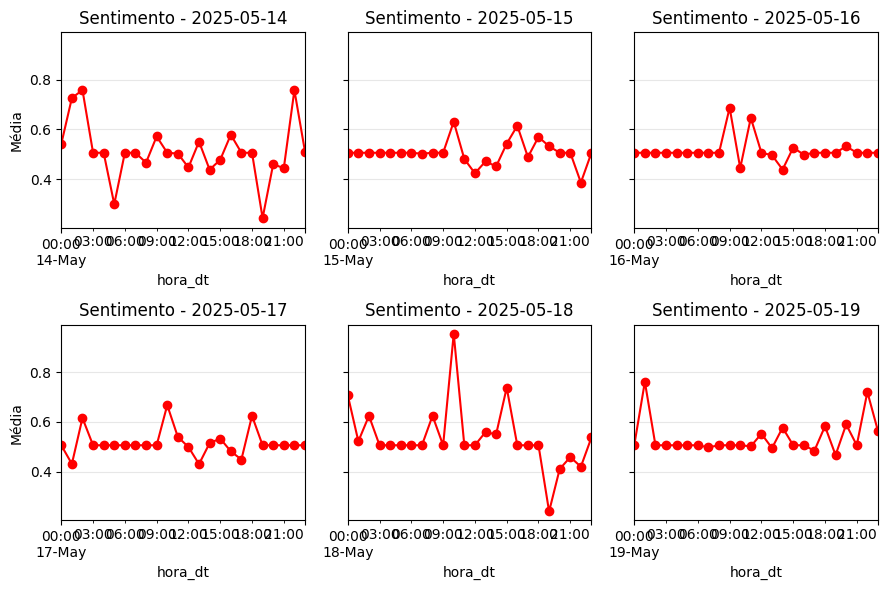

In [26]:
df_serie = df_hora.set_index("hora_dt").sort_index()
df_serie = df_serie["media"].resample("h").mean()
df_serie = df_serie.fillna(df_serie.mean())

dias = ["2025-05-14", "2025-05-15", "2025-05-16", "2025-05-17", "2025-05-18", "2025-05-19"]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize = (9,6), sharey = True)

axes = axes.flatten()

for i, dia in enumerate(dias):
    df_serie[dia].plot(ax = axes[i], color = "red", marker = "o", linestyle = "-")
    
    axes[i].set_title(f"Sentimento - {dia}")
    axes[i].set_ylabel("Média")
    axes[i].grid(True, alpha = .3)

plt.tight_layout()

Não existe um padrão específico

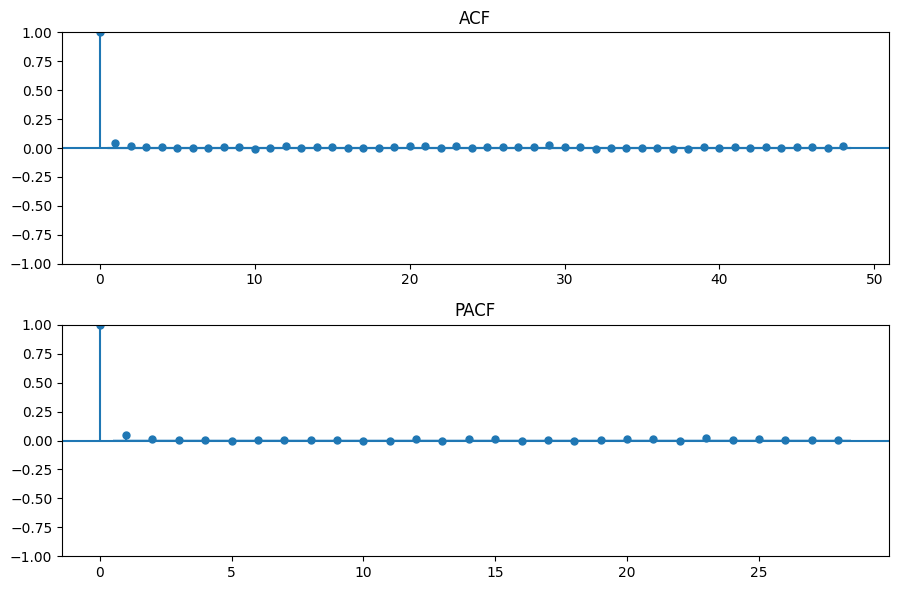

In [29]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize = (9,6))

plot_acf(df_serie, ax = ax1, lags = 48)
ax1.set_title("ACF")

plot_pacf(df_serie, ax = ax2, lags = 28, method = "ywm")
ax2.set_title("PACF")

plt.tight_layout()

Sem correlação, vamos seguir sem Série Temporal